In [4]:
'''
(C) Renata Wong

EXPERIMENTS ON H2 IN THE 6-31G BASIS
'''

from qiskit import QuantumCircuit, execute
from qiskit_aer import QasmSimulator

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA

import time
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from collections import Counter

from predicting_quantum_properties.prediction_shadow import estimate_exp
from modified_derandomization import modified_derandomized_classical_shadow

# handle deprecation issues
import qiskit_nature
#qiskit_nature.settings.use_pauli_sum_op = False   # reverts to SparsePauliOp type for the Hamiltonian
import h5py
H5PY_DEFAULT_READONLY=1






# classically obtained ground state energy
EXPECTED_EIGENVALUE = -1.87

# specifying the geometry of the molecule in question
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="6-31g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
hamiltonian = problem.hamiltonian
print(hamiltonian)

# electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
# Note: the qubit order in Qiskit string is qn qn-1 ... q1 q0
# while in Qikit circuit it is              q0 q1 ... qn-1 qn  (little endian)
mapper = BravyiKitaevMapper()
bkencoded_hamiltonian = mapper.map(second_q_op)
print(bkencoded_hamiltonian)
#for pauli in bkencoded_hamiltonian:
#    print(pauli)






def process_hamiltonian(hamiltonian, derandomize = False):

    hamiltonian_observables = []
    hamiltonian_coefficients = []
    
    for observable in hamiltonian:
        observable_str = str(observable)
        observable_str_clean = observable_str.strip()  # removes white spaces
        pauli_str_list = observable_str_clean.split('*')
        tuple_list = []
    
        for op_index, pauli_op in enumerate(pauli_str_list[1]):
            if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
                tuple_list.append((pauli_op, op_index-1))
        if len(tuple_list) > 0:
            hamiltonian_observables.append(tuple_list)
            hamiltonian_coefficients.append(float(pauli_str_list[0].strip()))

    system_size = len(hamiltonian_observables[0])

    # removing all occurrences of Pauli-I, for all-Pauli-I there is an empty list left
    # these observables are needed for estimate_exp()
    observables_xyze = []

    for observable in hamiltonian_observables:
        XYZE = []
        for pauli in observable:
            if pauli[0] != 'I':
                XYZE.append(pauli)
        observables_xyze.append(XYZE)   
    
    # derandomisation procedure requires that coefficients are non-negative
    if derandomize == True:
        absolute_coefficients = [abs(coeffcient) for coeffcient in hamiltonian_coefficients]

        # removing the empty list as well
        # these observables are needed for derandomisation procedure
        observables_xyz = []
        for idx, observable in enumerate(observables_xyze):
            if observable:
                observables_xyz.append(observable)
            else:
                absolute_coefficients.pop(idx)
        
        return system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients
    
    return system_size, observables_xyze, hamiltonian_coefficients



# process the Hamiltonian to obtain properly formatted data
hamiltonian_data = process_hamiltonian(bkencoded_hamiltonian, derandomize = True)
system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients = hamiltonian_data





reps = 1   
ansatz = EfficientSU2(system_size, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=False)  
    
    
    
    
    
def basis_change_circuit(pauli_op):

    #   Generating circuit with just the basis change operators
    #
    #       pauli_op: n-qubit Pauli operator

    basis_change = QuantumCircuit(ansatz.num_qubits)
    
    for idx, op in enumerate(pauli_op):
    #for idx, op in zip(reversed(range(len(pauli_op))), pauli_op):    # reversing order of Pauli operators 
        if op == 'X':
            basis_change.h(idx)
        elif op == 'Y':
            basis_change.h(idx)
            basis_change.p(-np.pi/2, idx)

    return basis_change



def min_cost():
    
    return min(cost_history)


def log_cost(cost):

    global cost_history
    cost_history.append(cost)
    
    


def objective_function(operators, params):
    
    backend = QasmSimulator(method='statevector', shots=1)
    
    pauli_op_dict = Counter(tuple(x) for x in operators)    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        
        qc = ansatz.bind_parameters(params)
        qc.compose(basis_change_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()    # given in order qn qn-1 ... q1 q0

        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values
                
                output_str = list(count)
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                snapshot.reverse()
                
                shadow.append(snapshot)
    
    
    cost = 0.0
    for term, weight in zip(observables_xyze, hamiltonian_coefficients):
        
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = sum_product / match_count
            cost += weight * exp_val
            
    log_cost(cost)
    
    return cost


1.5280210592332606 * IIIIIIII
- 0.2722152573510047 * IIIIIIIZ
+ 0.08812294324841644 * IIIIIYYX
- 0.08812294324841645 * IIIIIXYY
- 0.40516889844632514 * IIIIIIZZ
- 0.052063680664412464 * IIIIZIXZ
+ 0.052063680664412464 * IIIIIZXI
- 0.6893596033215883 * IIIIIZII
- 1.0422225890818178 * IIIIZZZI
- 0.272215257351005 * IIIZIIII
+ 0.08812294324841646 * IYYXIIII
- 0.08812294324841646 * IXYYIIII
- 0.4051688984463249 * IIZZIIII
- 0.0520636806644124 * ZIXZZIII
+ 0.0520636806644124 * IZXIIIII
- 0.689359603321588 * IZIIIIII
- 1.042222589081817 * ZZZIZIII
+ 0.08852206158533463 * IIIIIIZI
+ 0.016033305580190997 * IIIIZIXI
- 0.016033305580190997 * IIIIIZXZ
+ 0.1057199933083189 * IIIIIZIZ
+ 0.13179934521156542 * IIIIZZZZ
- 0.01735600095509334 * IIIIIYXY
- 0.01735600095509334 * IIIIIXXX
+ 0.012970529275601939 * IIIIZYZY
+ 0.015318666338180957 * IIIIZXIX
- 0.002348137062579003 * IIIIIXZX
- 0.002348137062579003 * IIIIZXZX
+ 0.015318666338180957 * IIIIIXIX
+ 0.012970529275601939 * IIIIIYZY
+ 0.019831904813

In [5]:
'''
Use classical eigensolver to obtain the ground state energy for the molecule of interest. 
This value is ca. -1.87 and will be used for evaluating the accuracy of the results found by the quantum-classical method.
'''

converter = BravyiKitaevMapper() 
numpy_solver = NumPyMinimumEigensolver()   

calc = GroundStateEigensolver(converter, numpy_solver)
res = calc.solve(problem)
print('Electronic ground state energy found using classical eigensolver:\n', res) 

Electronic ground state energy found using classical eigensolver:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.871583314386
  - computed part:      -1.871583314386
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.151614319937
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948701555]
    - computed part:      [0.0  0.0  1.388948701555]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000001555]  Total: 0.000000001555
                 (debye): [0.0  0.0  -0.000000003953]  Total: 0.000000003953
 


NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR

EXPERIMENT 0: GROUND STATE ENERGY FOUND = 1.4258972048286864
50 | Counter({('X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'): 50}) | 3.2958972048286865
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -0.27169048128548395
250 | Counter({('X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'): 249, ('Z', 'Z', 'Z', 'X', 'Z', 'Z', 'Z', 'X'): 1}) | 1.5983095187145162
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.9298550252579776
500 | Counter({('X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'): 498, ('Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z'): 1, ('Z', 'Z', 'Z', 'X', 'Z', 'Z', 'Z', 'X'): 1}) | 0.05985502525797748
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -2.1278225275149483
750 | Counter({('X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'): 746, ('Z', 'Z', 'Z', 'X', 'Z', 'Z', 'Z', 'X'): 3, ('Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z'): 1}) | 0.25782252751494816
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.7207151885946512
1000 | Counter({('X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'): 995,

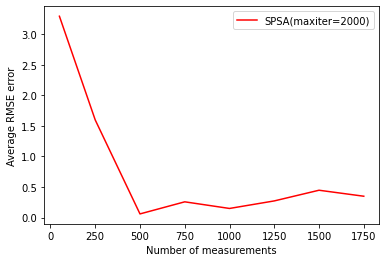

In [6]:
'''
RUNNING EXPERIMENTS
''' 

start_time = time.time()
rmse_errors = []

print('NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR\n')
measurement_range = [50, 250, 500, 750, 1000, 1250, 1500, 1750]

for num_operators in measurement_range:   
    
    derandomized_hamiltonian = modified_derandomized_classical_shadow(observables_xyz, num_operators, 
                                                                      system_size, weight=absolute_coefficients)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)

    optimizer = SPSA(maxiter=2000) 
    cost_function = partial(objective_function, derandomized_hamiltonian)
    
    expectation_values = []
    num_experiments = 1


    for iteration in range(num_experiments):
        
        cost_history = []
        
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        minimal_cost = min_cost()
        expectation_values.append(minimal_cost)
                
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, minimal_cost))


    rmse_derandomised_cs = np.sqrt(np.sum([(expectation_values[i] - EXPECTED_EIGENVALUE)**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    
    print('{} | {} | {}'.format(num_operators, counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

          
points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='SPSA(maxiter=2000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)

In [ ]:

'''
RUNNING EXPERIMENTS ON OVERGENERATED OPERATORS: TO DO
''' 

start_time = time.time()
rmse_errors = []


import random

# generate 15K operators, then remove the most common ones till we reach the required number
overgenerated_derandomized_operators = modified_derandomized_classical_shadow(observables_xyz, 15000, 
                                                                      system_size, weight=absolute_coefficients)


tuples = (tuple(pauli) for pauli in overgenerated_derandomized_operators)
counts = Counter(tuples)

measurement_range = [50, 250, 500, 750, 1000, 1250, 1500, 1750]
reduced_measurements = []
for num_operators in measurement_range:
    operators = random.choices(list(counts.keys()), weights=[1/weight for weight in counts.values()], k=num_operators)
    reduced_measurements.append(operators)
    count_dict = Counter(tuple(pauli) for pauli in operators)
        




print('NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR\n')

for operators in reduced_measurements:   

    counts = Counter(tuple(pauli) for pauli in operators)
    
    optimizer = SPSA(maxiter=2000) 
    cost_function = partial(objective_function, operators)
    
    expectation_values = []
    num_experiments = 1


    for iteration in range(num_experiments):
        
        cost_history = []
        
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        minimal_cost = min_cost()
        expectation_values.append(minimal_cost)
                
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, minimal_cost))


    rmse_derandomised_cs = np.sqrt(np.sum([(expectation_values[i] - EXPECTED_EIGENVALUE)**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    
    print('{} | {} | {}'.format(num_operators, counts, rmse_derandomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

          
points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'g', label='SPSA(maxiter=2000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)


NUMBER OF OPERATORS | DERANDOMISED OPERATORS | AVERAGE RMSE ERROR

EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.707403391181709
1750 | Counter({('X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'): 14867, ('X', 'Z', 'Z', 'Z', 'X', 'Z', 'Z', 'Z'): 28, ('Z', 'Z', 'Z', 'Z', 'X', 'Z', 'Z', 'Z'): 16, ('X', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z'): 12, ('Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z'): 9, ('Y', 'Z', 'Z', 'Z', 'X', 'Z', 'Z', 'Z'): 5, ('X', 'Z', 'X', 'Z', 'X', 'Z', 'X', 'Z'): 2, ('Z', 'Z', 'Z', 'Z', 'X', 'Y', 'Y', 'X'): 2, ('Z', 'Z', 'Z', 'Z', 'Y', 'Y', 'X', 'X'): 2, ('Z', 'X', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z'): 2, ('X', 'Y', 'Y', 'Z', 'Z', 'Z', 'Z', 'Z'): 2, ('Y', 'Y', 'X', 'Z', 'Z', 'Z', 'Z', 'Z'): 2, ('X', 'X', 'Z', 'Z', 'Z', 'Z', 'X', 'Z'): 2, ('Z', 'Z', 'Z', 'Z', 'Z', 'X', 'Z', 'Z'): 2, ('Y', 'Y', 'X', 'Z', 'X', 'Y', 'Y', 'X'): 2, ('Y', 'Y', 'Z', 'Z', 'Y', 'Y', 'Z', 'X'): 2, ('X', 'Y', 'Y', 'Z', 'Y', 'Y', 'X', 'X'): 2, ('Y', 'Y', 'X', 'Z', 'Y', 'Y', 'X', 'X'): 2, ('X', 'Y', 'Y', 'Z', 'X', 'Y', 'Y', 'X'